In [5]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
! pip install category_encoders
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import os


Final RMSE: 1844.1422
Final R²:   0.5832
Final MAE:  1171.9867

Top 20 Most Important Features:
cat80     0.160469
cat57     0.089896
cat79     0.059319
cat12     0.050581
cat113    0.026266
cat101    0.022149
cat81     0.021944
cat72     0.019471
cont2     0.019143
cat108    0.019081
cat87     0.016729
cat53     0.014961
cat109    0.013986
cont7     0.013496
cont12    0.012846
cat1      0.012572
cat116    0.011582
cat111    0.011480
cat103    0.011412
cat100    0.010674
dtype: float32


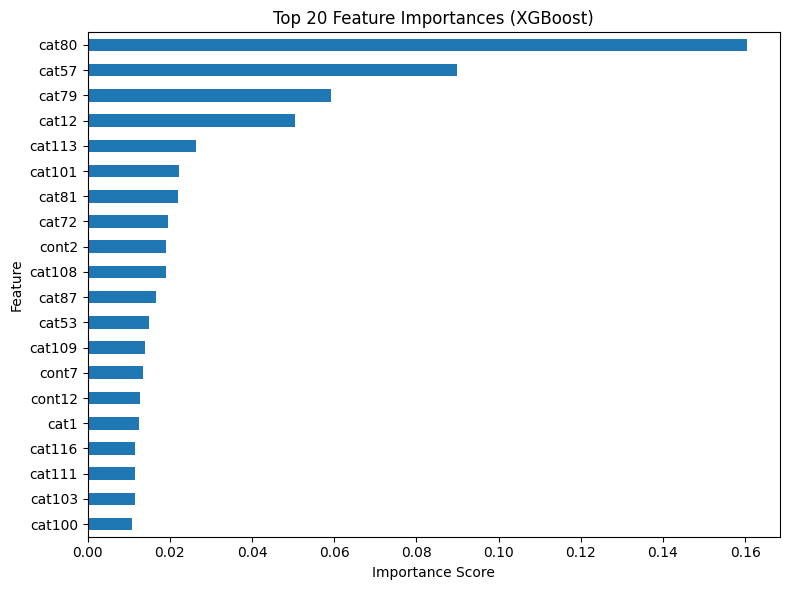

In [11]:
# 1. Load data
filename = '/content/claims_data.csv'
df = pd.read_csv(filename)

# 2. Drop rows with missing or invalid target values
df = df[df['loss'].notna() & (df['loss'] >= 0)]

# 3. Separate features and target
X = df.drop(columns=['loss'])
y = df['loss']

# 4. Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# 5. Target encode categorical columns
if cat_cols:
    te = TargetEncoder(cols=cat_cols)
    X = te.fit_transform(X, y)

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. Define XGBoost model
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='rmse'
)

# 8. Fit model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)

print(f"\nFinal RMSE: {rmse:.4f}")
print(f"Final R²:   {r2:.4f}")
print(f"Final MAE:  {mae:.4f}")

# 11. Feature importance (Top 20)
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
top20 = feat_importances.sort_values(ascending=False).head(20)

print("\nTop 20 Most Important Features:")
print(top20)

# Plot feature importances
plt.figure(figsize=(8,6))
top20.sort_values().plot(kind='barh')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Top 20 Most Important Features:
cat80     0.160469
cat57     0.089896
cat79     0.059319
cat12     0.050581
cat113    0.026266
cat101    0.022149
cat81     0.021944
cat72     0.019471
cont2     0.019143
cat108    0.019081
cat87     0.016729
cat53     0.014961
cat109    0.013986
cont7     0.013496
cont12    0.012846
cat1      0.012572
cat116    0.011582
cat111    0.011480
cat103    0.011412
cat100    0.010674
dtype: float32

Reduced Model (Top 20 Features):
RMSE: 1891.4328
R²:   0.5616
MAE:  1219.1933


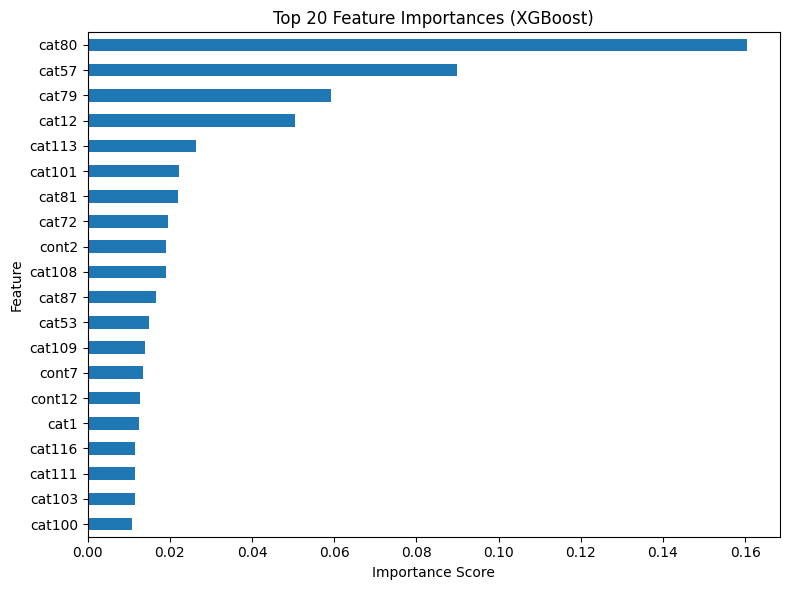

In [12]:
#Define the list of top 20 feature names
top20_features = top20.index.tolist()

print("\nTop 20 Most Important Features:")
print(top20)

# 11. Retrain model using only top 20 features
X_top20 = X[top20_features]
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_top20, y, test_size=0.2, random_state=42
)

model_top20 = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='rmse'
)

model_top20.fit(
    X_train2, y_train2,
    eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
    verbose=False
)

# 12. Evaluate reduced model
y_pred2 = model_top20.predict(X_test2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
r22   = r2_score(y_test2, y_pred2)
mae2  = mean_absolute_error(y_test2, y_pred2)

print(f"\nReduced Model (Top 20 Features):")
print(f"RMSE: {rmse2:.4f}")
print(f"R²:   {r22:.4f}")
print(f"MAE:  {mae2:.4f}")

# 13. Plot top 20 feature importances
plt.figure(figsize=(8,6))
top20.sort_values().plot(kind='barh')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()